# Gradient boosting classifier

### Importing the data

In [1]:
# @hidden_cell
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'admin_c24f02ccead8f3d4baea656ecbccd8e6e38d474d','domain': {'id': '8d5c5723b93e4bdf8c5be53de58a2395'},
            'password': 'D!~GY/p7Z]b##1oV'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

data_train = pd.read_csv(get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f('seminaire_data', 'Transformed_features.csv'), index_col=False)
data_train.head()

,Unnamed: 0,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


### Preparing the data (normalization, splitting train and test ... )

In [2]:
data_train = data_train.iloc[:, 1:]

In [3]:
data_train.head()

,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,management_fnr,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,0.099002,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,0.065166,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


In [4]:
# Transforming the data into numpy arrays

Y = (data_train.target).tolist()
y = np.asarray(Y)

In [5]:
# Dropping the y column and the time column

data_train.drop('target', axis=1, inplace=True)

In [6]:
# Transforming the data frame into an array

X = data_train.as_matrix()
X.shape

# First we fill the Nan values with the mean (first approach)

X = np.where(np.isnan(X), np.ma.array(X, mask = np.isnan(X)).mean(axis=0), X)

In [7]:
# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

#Splitting the data into training and test sets (80% (includes the cross validation set) - 20%)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:((4 * X.shape[0]) / 5)], indices[((4 * X.shape[0]) / 5):]
X_train, y_train, X_test, y_test = X[train_idx,:], y[train_idx], X[test_idx,:], y[test_idx]

### Gradient boosting

Gradient boosting is a technique in machine learning that allows us to obtain a better algorithm for our task. The idea behind gradient boosting is that we can build a good algorithm, by learning a sequence of weak models (e.g linear regression, decision tree, ...), in which every new model improves on some optimized linear combination of the previous models. It has been shown to provide drastic increase in performance compared to the weak model used.

In this notebook, we'll use a gradient boosting classifier based on decision trees, which is known as gradient boosting forest. Here we can also control the number of trees to use and the number of features to use when splitting the tree. But since the computation time is very long for this algorithm, and since it does not overfit whatsoever, we chose to study only the influence of the depth of the trees.

0
1
2
3
4
5
6
7


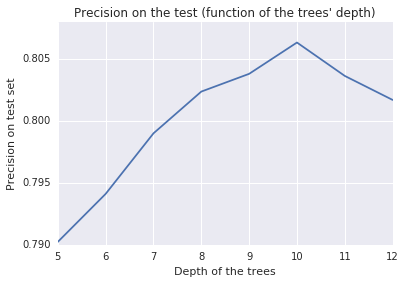

In [8]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

depth_max = 13
depth_start = 5

D = X_train.shape
depths = range(depth_start,depth_max)

precisions = np.zeros(depth_max - depth_start)
list_gbc = []

for k in xrange(depth_max - depth_start):
    print(k)
    classifier = gbc(loss='deviance',max_depth = depths[k])
    classifier.fit( X_train, y_train)
    list_gbc.append(classifier)
    pred = classifier.predict(X_test)
    precisions[k] = np.mean((pred == y_test))
    
plt.figure()
plt.plot(depths[: depth_max - depth_start],precisions)
plt.xlabel('Depth of the trees')
plt.ylabel('Precision on test set')
plt.title("Precision on the test (function of the trees' depth)")
plt.show()

